In [1]:
import pandas as pd
import numpy as np
import scipy
import powerlaw
import ultraplot as uplt

In [2]:
import skimage

In [3]:
im = skimage.io.imread("/Users/dmw/Downloads/20140424_ice_mask.tiff")

In [4]:
skimage.io.imsave("../data/MODIS_JOG_example_case/20140424_ice_mask.png", im*255)

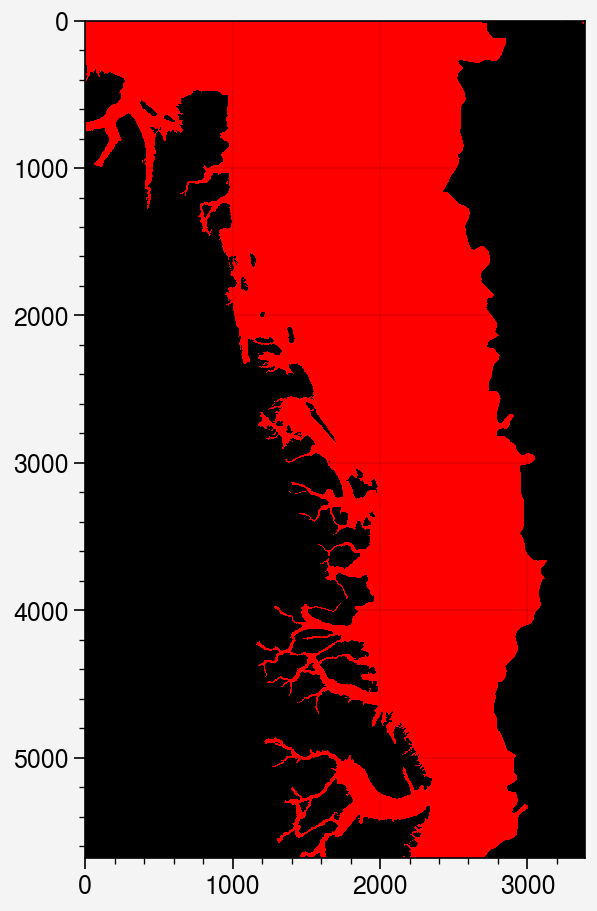

In [5]:
fig, ax = uplt.subplots()
ax.imshow(im * 255)

Back of the envelope: If every date has enough images to run the whole algorithm, we'd expect April - September to have 
360 images (2 per day). So for a full season, it would take 20 hours to run the algorithm on my Mac mini. This of course could be easily parallelized so we could run the whole thing on Oscar quite quickly.



In [13]:
360 * 192 / 60 / 60

19.2

# Example of floe size distribution

In [38]:
tc_img = skimage.io.imread("../data/MODIS_JOG_example_case/truecolor/20140428.aqua.truecolor.250m.tiff")
colorized_img = skimage.io.imread("../data/MODIS_JOG_example_case/updated_proc/colorized/20140428.aqua.colorized.250m.png")
labeled_img = skimage.measure.label(colorized_img.sum(axis=2))

colorized_img_init = skimage.io.imread("../data/MODIS_JOG_example_case/labeled_init/20140428.aqua.init_colorized_image.tiff")
labeled_img_init = skimage.measure.label(colorized_img_init.sum(axis=2))

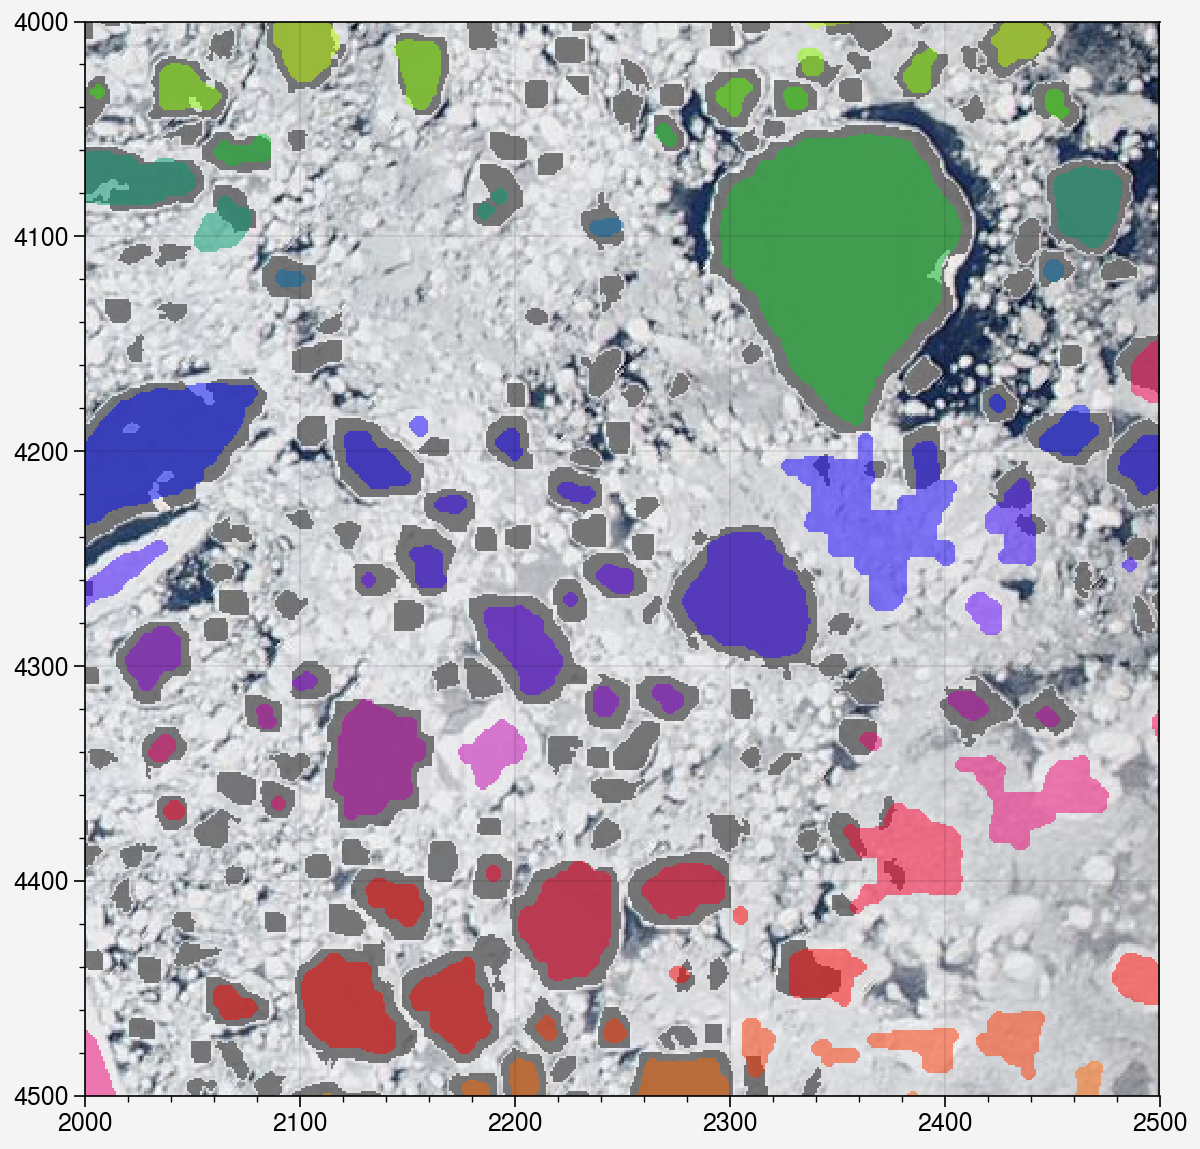

In [41]:
fig, ax = uplt.subplots(ncols=1, width=6)
ax.imshow(tc_img)
ax.imshow(np.ma.masked_array(labeled_img, labeled_img == 0), c='k', alpha=0.5)
ax.imshow(np.ma.masked_array(labeled_img_init, labeled_img_init == 0), cmap='prism', alpha=0.5)
ax.format(ylim=(4500, 4000), xlim=(2000, 2500))

# TBD: further image cleanup
* Test using the function we use to fit and parameterize the boundaries
  * Potential to use gradient snakes algorithm

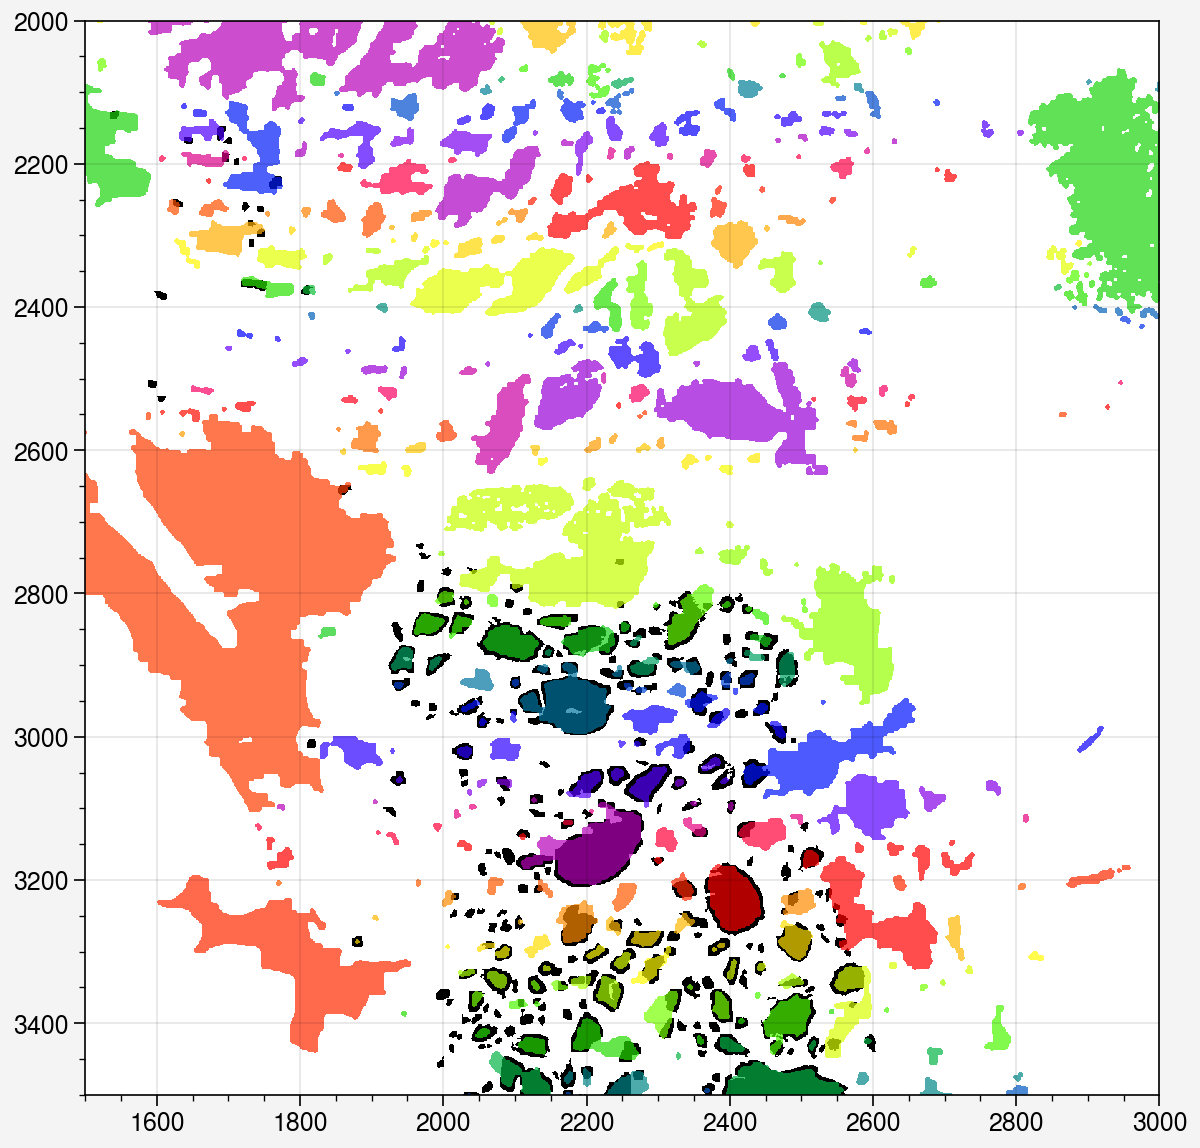

In [37]:
fig, ax = uplt.subplots(ncols=1, width=6)
ax.imshow(np.ma.masked_array(labeled_img, labeled_img == 0), c='k')
ax.imshow(np.ma.masked_array(labeled_img_init, labeled_img_init == 0), cmap='prism', alpha=0.7)
ax.format(ylim=(3500, 2000), xlim=(1500, 3000))

In [13]:
props = pd.DataFrame(skimage.measure.regionprops_table(labeled_img, properties=['label', 'area', 'centroid', 'convex_area']))
props_init = pd.DataFrame(skimage.measure.regionprops_table(labeled_img_init, properties=['label', 'area', 'centroid', 'convex_area']))

In [14]:
areas = np.zeros(labeled_img.shape)
for ii in props['label']:
    areas[labeled_img == ii] = props.loc[props.label==ii, 'area']

In [22]:
import os
files = os.listdir('../data/MODIS_JOG_example_case/updated_proc/')
for file in files:
    if 'colorized' in file:
        date, satellite, _, _, _ = file.split('.')
        colorized_img = skimage.io.imread("../data/MODIS_JOG_example_case/updated_proc/" + file)
        labeled_img = skimage.measure.label(colorized_img.sum(axis=2))
        
        props = pd.DataFrame(skimage.measure.regionprops_table(labeled_img, properties=['label', 'area', 'centroid', 'convex_area']))
        areas = np.zeros(labeled_img.shape)
        for ii in props['label']:
            areas[labeled_img == ii] = props.loc[props.label==ii, 'area']
        fig, ax = uplt.subplots(height=6)
        ax.imshow(np.ma.masked_array(areas, mask=(areas == 0)), color='red6')
        ax.imshow(np.ma.masked_array(areas, mask=(areas < 800)), color='gold') # 50 km
        ax.imshow(np.ma.masked_array(areas, mask=(areas < 1600)), color='lilac') # 100 km
        ax.imshow(np.ma.masked_array(areas, mask=(areas < 2500)), color='blue5') # 150 km
        
        h, l = [], []
        for label, color in zip (['0-50 km$^2$', '50-100 km$^2$', '100-150 km$^2$', '$>$150 km$^2$'],
                                 ['red6', 'gold', 'lilac', 'blue5']):
            h.append(ax.plot([], [], color=color, lw=0, marker='s'))
            l.append(label)
            ax.legend(h, l, ncol=1, loc='ll')
            ax.format(yreverse=True, xticks='none', yticks='none', ylim=(2000, 4000), xlim=(1500, 3000))
        fig.save('../figures/animations/zoomed_image_fsd_' + date + '.' + satellite + '.png', dpi=300)
        uplt.close(fig)

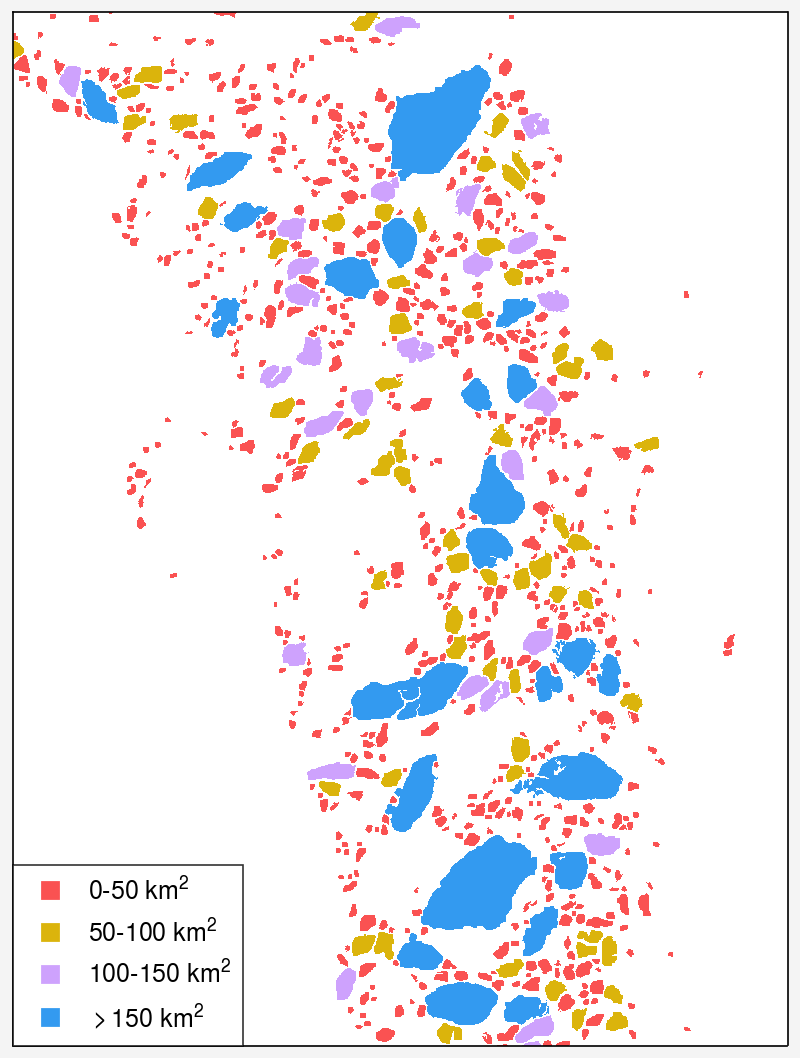

In [64]:
fig, ax = uplt.subplots(width=4)
ax.imshow(np.ma.masked_array(areas, mask=(areas == 0)), color='red6')
ax.imshow(np.ma.masked_array(areas, mask=(areas < 800)), color='gold') # 50 km
ax.imshow(np.ma.masked_array(areas, mask=(areas < 1600)), color='lilac') # 100 km
ax.imshow(np.ma.masked_array(areas, mask=(areas < 2500)), color='blue5') # 150 km

h, l = [], []
for label, color in zip (['0-50 km$^2$', '50-100 km$^2$', '100-150 km$^2$', '$>$150 km$^2$'],
                         ['red6', 'gold', 'lilac', 'blue5']):
    h.append(ax.plot([], [], color=color, lw=0, marker='s'))
    l.append(label)
ax.legend(h, l, ncol=1, loc='ll')
ax.format(ylim=(1000, 3000), xlim=(1300, 2800), yreverse=True, xticks='none', yticks='none')
fig.save('../figures/schematic_fsd.png', dpi=300)

Alpha (updated) 1.546478059089251
Alpha (initial) 1.5808967490416985


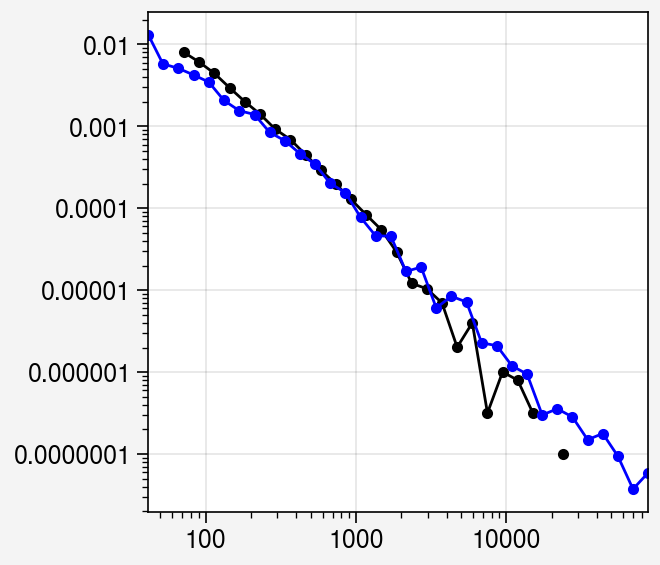

In [23]:
import ultraplot as uplt
import powerlaw

fig, ax = uplt.subplots()
fit = powerlaw.Fit(props['area'], xmin=35, xmax=1e5)
fit.plot_pdf(color='k', linewidth=1, alpha=1, ax=ax, marker='.')
print("Alpha (updated)", fit.alpha)

fit = powerlaw.Fit(props_init['area'], xmin=35, xmax=1e5)
fit.plot_pdf(color='b', linewidth=1, alpha=1, ax=ax, marker='.')
print("Alpha (initial)", fit.alpha)
# fit.plot_ccdf(color='gray', linewidth=1, alpha=0.5, ax=ax)

# Floe size distribution
Across this short series, we've got a very consistent alpha parameter.

Alpha (updated) 1.5673438101410428
Alpha (updated) 1.6358466177977653
Alpha (updated) 1.5672058081856428
Alpha (updated) 1.6077781447286776
Alpha (updated) 1.6303963593251551
Alpha (updated) 1.6461674492105698
Alpha (updated) 1.565165071987856
Alpha (updated) 1.5742903554545813
Alpha (updated) 1.600299847807677
Alpha (updated) 1.549111916736936
Alpha (updated) 1.554260826529704
Alpha (updated) 1.5203601028656681
Alpha (updated) 1.5442021868653613
Alpha (updated) 1.555859924854735
Alpha (updated) 1.5611743910801377
Alpha (updated) 1.546478059089251


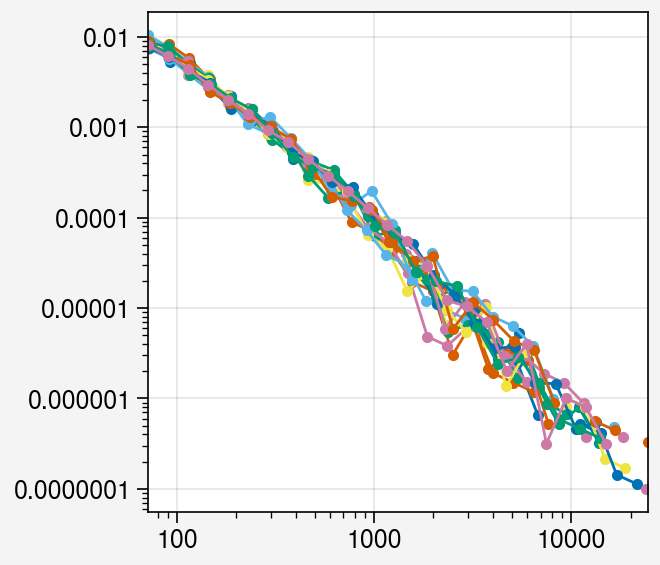

In [27]:
fig, ax = uplt.subplots()
files = [file for file in files if 'colorized' in file]
for file in files:
    colorized_img = skimage.io.imread("../data/MODIS_JOG_example_case/updated_proc/colorized/" + file)
    labeled_img = skimage.measure.label(colorized_img.sum(axis=2))
    props = pd.DataFrame(skimage.measure.regionprops_table(labeled_img, properties=['label', 'area', 'centroid', 'convex_area']))

    fit = powerlaw.Fit(props['area'], xmin=35, xmax=1e5)
    fit.plot_pdf(linewidth=1, alpha=1, ax=ax, marker='.')
    print("Alpha (updated)", fit.alpha)
# fit = powerlaw.Fit(props_init['area'], xmin=35, xmax=1e5)
# fit.plot_pdf(color='b', linewidth=1, alpha=1, ax=ax, marker='.')

In [28]:
df = pd.read_csv("../data/MODIS_JOG_example_case/tracked_floes_20140426-20140430.csv")

In [29]:
df.groupby("ID").filter(lambda x: len(x) > 6)["ID"].unique()

array([  11,   17,   29,   39,   55,  145,  146,  154,  156,  187,  197,
        221,  239,  288,  312,  320,  327,  359,  372,  379,  411,  452,
        491,  505,  506,  508,  531,  562,  626,  631,  650,  661,  665,
        782,  794,  884,  912,  915,  928,  943,  970,  982,  985, 1042,
       1047, 1051, 1084, 1090, 1091, 1096, 1125, 1167, 1177, 1193, 1214,
       1230, 1242, 1253, 1270, 1292, 1296, 1309, 1319, 1353, 1361, 1366,
       1367, 1412, 1420, 1444, 1457, 1465, 1472, 1503, 1506, 1530, 1557,
       1559, 1578, 1581, 1608, 1634, 1636, 1676, 1685, 1701, 1708, 1738,
       1744, 1746, 1776, 1795, 1812, 1830, 1856, 1870, 1873, 1877, 1889,
       1929, 1964, 1979, 1991, 2021, 2027, 2039, 2043, 2054, 2065, 2125,
       2157, 2164, 2172, 2213, 2224, 2260, 2263, 2278, 2282, 2287, 2295,
       2299, 2327, 2332, 2366, 2394, 2473, 2479, 2517, 2534, 2538, 2546,
       2553, 2569, 2599, 2617, 2673, 2676, 2679, 2703, 2720])

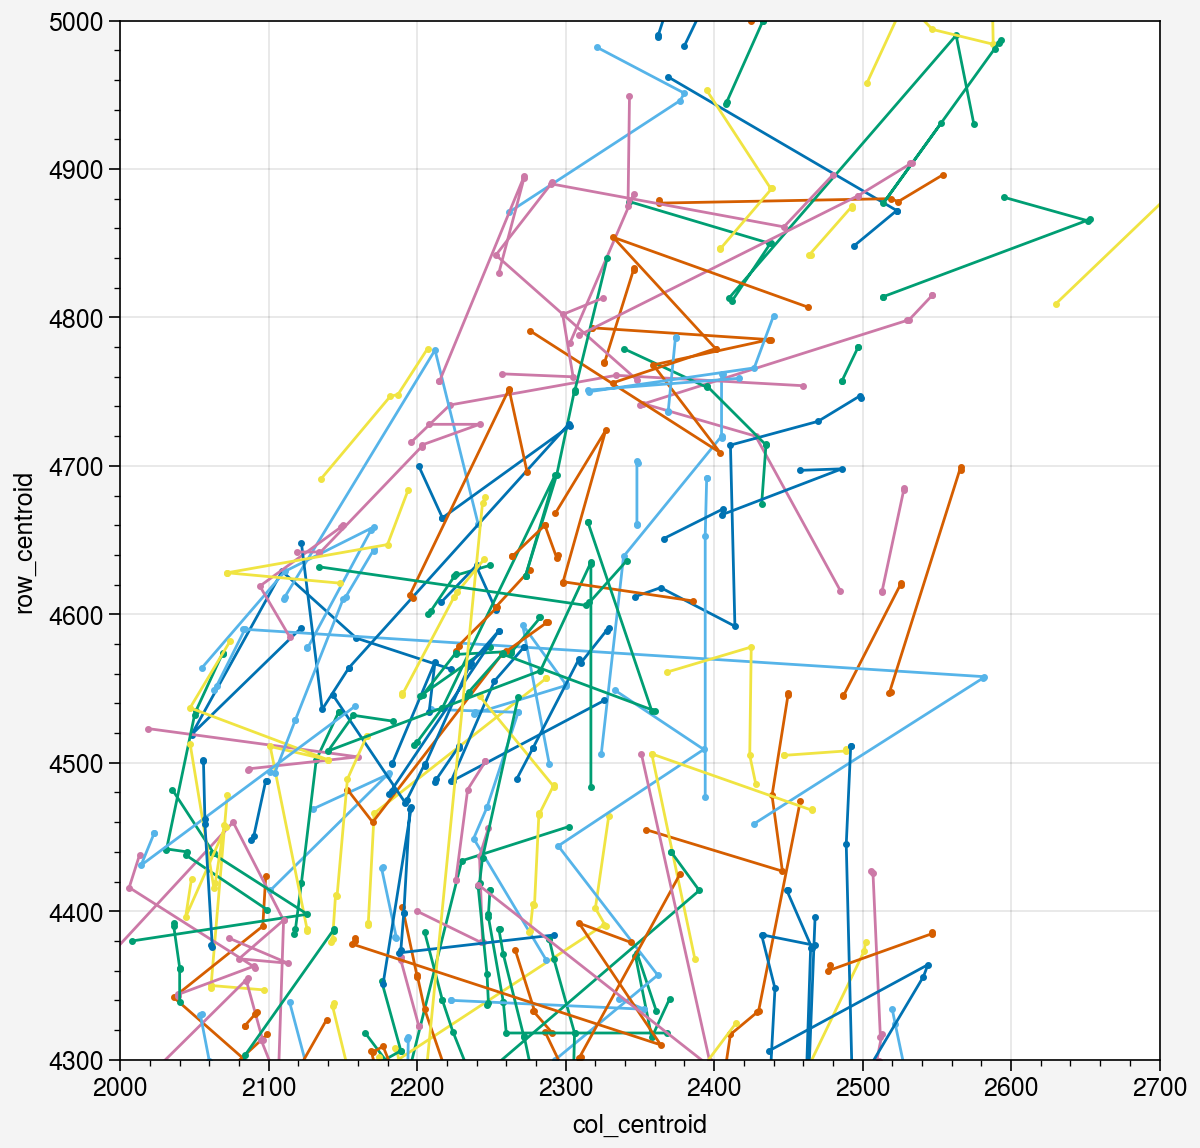

In [30]:
fig, ax = uplt.subplots(width=6)
# ax.imshow(labeled_img)
for ID in df.groupby("ID").filter(lambda x: len(x) > 3)["ID"].unique():
    ax.plot(df.loc[df.ID == ID, 'col_centroid'],
        df.loc[df.ID == ID, 'row_centroid'], marker='.', ms=3, lw=1)
ax.format(ylim=(4300, 5000), xlim=(2000, 2700))